In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Importing necessary libraries and packages**


In [2]:
#imports
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

# **Importing Dataset**

In [3]:
dataset = torchvision.datasets.FashionMNIST(root='./data', download=True, transform=ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root='./data',download=True, train=False, transform=ToTensor())


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


# **Describing Dataset**

In [4]:
dataset_size =len(dataset)
print("size of dataset: ",dataset_size)

size of dataset:  60000


In [5]:
test_dataset_size = len(test_dataset)
print("size of test data: ",test_dataset_size)

size of test data:  10000


In [6]:
classes = dataset.classes
print("classes in the dataset: ")
classes

classes in the dataset: 


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [7]:
num_classes = len(dataset.classes)
print("number of classes: ",num_classes)

number of classes:  10


In [8]:
img, label = dataset[0]
img_shape = img.shape
print("shape of image: ",img_shape)

shape of image:  torch.Size([1, 28, 28])


# Defining Batch Size

In [71]:
batch_size=128

# Defining training and validation data size

In [103]:
torch.manual_seed(43)
val_size = 12000
train_size = len(dataset) - val_size

In [104]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(48000, 12000)

# Defining Data Loaders

In [105]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_dataset, batch_size*2)

# Visualizing training data

images.shape: torch.Size([128, 1, 28, 28])


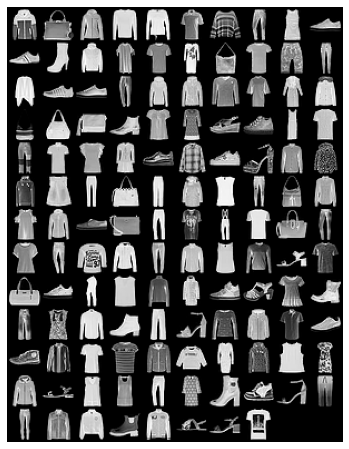

In [106]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))
    break

# Defining input size and number of classes in the data

In [107]:
input_size = 28*28
num_classes = 10

# Building the Model

In [108]:
class predictionmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = predictionmodel()

In [109]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Plot loss and accuracy functions

In [110]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [111]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

# Evaluating Model

In [112]:
history=[evaluate(model, val_loader)]
history

[{'val_loss': 2.299960136413574, 'val_acc': 0.07633216679096222}]

# Training the model using fit function to reduce loss and increase accuracy

In [82]:
epochs = 10
lr = 0.0001
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 2.2092, val_acc: 0.2144
Epoch [1], val_loss: 2.1234, val_acc: 0.3380
Epoch [2], val_loss: 2.0488, val_acc: 0.4706
Epoch [3], val_loss: 1.9817, val_acc: 0.5333
Epoch [4], val_loss: 1.9204, val_acc: 0.5694
Epoch [5], val_loss: 1.8640, val_acc: 0.5902
Epoch [6], val_loss: 1.8120, val_acc: 0.6039
Epoch [7], val_loss: 1.7640, val_acc: 0.6129
Epoch [8], val_loss: 1.7194, val_acc: 0.6217
Epoch [9], val_loss: 1.6780, val_acc: 0.6247


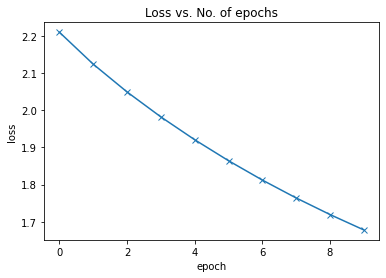

In [83]:
plot_losses(history1)

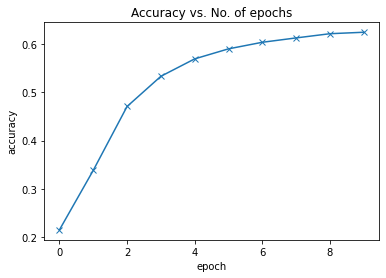

In [84]:
plot_accuracies(history1)

In [114]:
epochs = 10
lr = 0.01
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8123, val_acc: 0.7434
Epoch [1], val_loss: 0.7242, val_acc: 0.7710
Epoch [2], val_loss: 0.6743, val_acc: 0.7844
Epoch [3], val_loss: 0.6431, val_acc: 0.7930
Epoch [4], val_loss: 0.6191, val_acc: 0.8025
Epoch [5], val_loss: 0.6004, val_acc: 0.8050
Epoch [6], val_loss: 0.5868, val_acc: 0.8092
Epoch [7], val_loss: 0.5734, val_acc: 0.8135
Epoch [8], val_loss: 0.5644, val_acc: 0.8175
Epoch [9], val_loss: 0.5553, val_acc: 0.8203


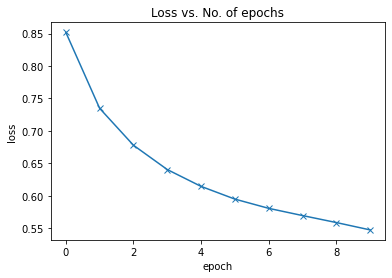

In [86]:
plot_losses(history1)

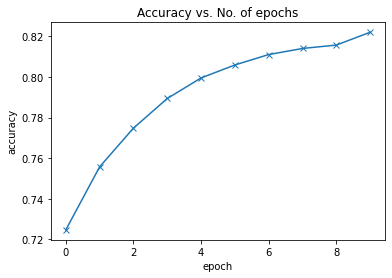

In [87]:
plot_accuracies(history1)

In [118]:
epochs = 5
lr = 0.1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4358, val_acc: 0.8513
Epoch [1], val_loss: 0.4396, val_acc: 0.8473
Epoch [2], val_loss: 0.4381, val_acc: 0.8511
Epoch [3], val_loss: 0.4321, val_acc: 0.8524
Epoch [4], val_loss: 0.4314, val_acc: 0.8525
Epoch [5], val_loss: 0.4510, val_acc: 0.8472
Epoch [6], val_loss: 0.4270, val_acc: 0.8558
Epoch [7], val_loss: 0.4493, val_acc: 0.8475


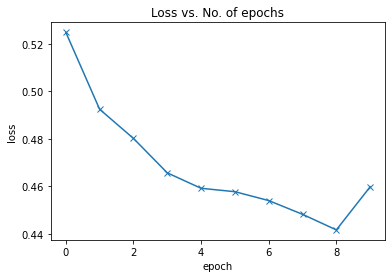

In [116]:
plot_losses(history1)

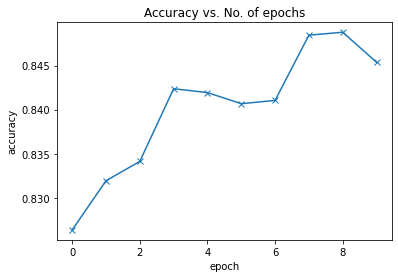

In [117]:
plot_accuracies(history1)

# Evaluate model on test data

In [91]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.5588424801826477, 'val_acc': 0.814160168170929}

# Predictions on model

In [30]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: Sandal , Predicted: Sandal


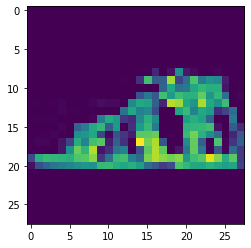

In [31]:
img, label = test_dataset[11]
plt.imshow(img[0])
x = label
label = classes[x]
print('Label:', label, ', Predicted:', classes[predict_image(img, model)])

Label: Pullover , Predicted: T-shirt/top


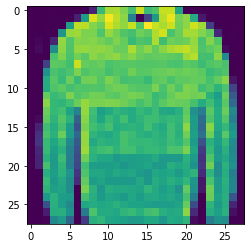

In [32]:
img, label = test_dataset[20]
plt.imshow(img[0])
x = label
label = classes[x]
print('Label:', label, ', Predicted:', classes[predict_image(img, model)])

Label: T-shirt/top , Predicted: T-shirt/top


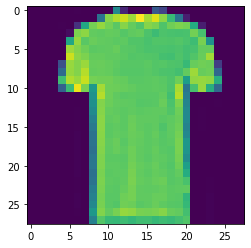

In [33]:
img, label = test_dataset[88]
plt.imshow(img[0])
x = label
label = classes[x]
print('Label:', label, ', Predicted:', classes[predict_image(img, model)])

Label: T-shirt/top , Predicted: T-shirt/top


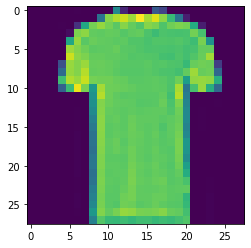

In [34]:
img, label = test_dataset[88]
plt.imshow(img[0])
x = label
label = classes[x]
print('Label:', label, ', Predicted:', classes[predict_image(img, model)])

In [35]:
!pip install jovian --upgrade --quiet

In [67]:
import jovian


In [68]:
jovian.commit(project="fashion_mnist_project", environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Please enter your API key ( from https://jovian.ml/ ):
API KEY: 


Abort: 

In [ ]:
jovian.reset()
jovian.log_hyperparams(batch_size=batch_size, learning_rate=0.001)